# Due date:
October 3rd

# Problem statement

You are part of a trading team that makes investments based on [Fundamental Analysis](https://https://en.wikipedia.org/wiki/Fundamental_analysis).

Your job is to produce revenue growth forecasts for firms in a given industry based on financial charateristics of these firms and relevant economic data. Your forecasts are then used in a larger decision making system.

You have access to a dataset of 10,000 observations. Each observation $(X_i, y_i)$ consists of 20,000 economic and financial indicators that could presumably forecast revenue growth for the next quarter, and the corresponding revenue growth
for that observation ($y_i$).

The corresponding training and validation sets are given below:

X_train.py: https://drive.google.com/file/d/1djN8V5oLCL-CFnVXmDuMWs77-UO9z6CL


y_train.py: https://drive.google.com/file/d/1DYNpMf8rggc1toxftmTNIlKFWSUpIJTM

X_val.py: https://drive.google.com/file/d/13Sf6tFh4_N0W44OcreUqJErI79nPs5p6

y_val.py: https://drive.google.com/file/d/1BnvTDK_LOYEP0HLXL9gv_7XW3s8N47ax


# Task
Construct a linear model to forecast revenue growth based on the data you have. You model will be evaluated based on the mean squared error between your predictions and the labels evaluated at a test set. The test set comes from the same distribution as the training set and the evaluation set.



# Deliverables
You should send me the entire code used to solve the problem. You can send me either a colab link or a single .py file.

As part of you solution, you should also deliver a function.


In [ ]:
def f(X):
  ...
  return prediction



that returns the predictions of you model for a new dataset X.

Finally, your code should produce the solution in no more than 10 minutes running on colab.


# Group Member

Chang Gao (UIN: 671189915)

Hyoung Woo Hahm (UIN: 661790448)

Napaton Prasertthum (UIN: 675585068)

Saranpat Prasertthum (UIN: 655667271)

Yu-Ching Liao (UIN: 656724372)

# Solution

In [ ]:
pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing 

In [ ]:
# input data
X_train = jnp.load('/content/drive/MyDrive/IE553 Machine Learning in Finance/IE553 Project1/X_train.npy')
X_val = jnp.load('/content/drive/MyDrive/IE553 Machine Learning in Finance/IE553 Project1/X_val.npy')
y_train = jnp.load('/content/drive/MyDrive/IE553 Machine Learning in Finance/IE553 Project1/y_train.npy')
y_val = jnp.load('/content/drive/MyDrive/IE553 Machine Learning in Finance/IE553 Project1/y_val.npy')

In [ ]:
# Use Sklearn to spilit (we can cross validate this later)
# X_train1, X_test, y_train1, y_test = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state = 100)

In [ ]:
# Advanced Optimization - Adam
n_models = 4
optimizer = optax.adam
Θ = jnp.zeros(X_train.shape[1])
opt_state = optimizer(1.).init(Θ)
Θ = jnp.stack([Θ] * n_models)
opt_state = jax.tree_map(lambda item:jnp.stack([item] * n_models), opt_state)

In [ ]:
# MSE
def mse(a, b):
  return ((a - b)**2).mean()

# apply the gradient decent algorithm 
@jax.jit
@jax.vmap
def update(Θ, opt_state, Xi, yi, λ, lr):
  # MSE loss function
  def L(Θ, X, y, λ):
    predict = X @ Θ
    return mse(predict, y) + λ * Θ @ Θ #l1_norm/l2_norm ** l1_norm is better??

  grads = jax.grad(L)(Θ, Xi, yi, λ)
  updates, opt_state = optimizer(lr).update(grads, opt_state)
  Θ = optax.apply_updates(Θ, updates)
  return Θ, opt_state

@jax.jit
@jax.vmap
def evaluate(Θ):
  return mse(X_val @ Θ, y_val)

In [ ]:
# hyperpartameter tuning (random search)
batch_size = 512
λ = jnp.array([1e-1, 1e-2, 1e-4, 1e-5, 1e-6])
lr = jnp.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

rng = jax.random.PRNGKey(1234)
λ_try = jax.random.choice(rng, λ, [n_models])
rng = jax.random.PRNGKey(2234)
lr_try = jax.random.choice(rng, lr, [n_models])

print(lr_try)
print(λ_try)

[1.e-03 1.e-05 1.e-03 1.e-02]
[1.e-04 1.e-06 1.e-06 1.e-01]


In [ ]:
# sampling minibatches
@jax.jit
def sample(X, y, rng):
  Xi = jnp.zeros([n_models, batch_size, X.shape[1]])
  yi = jnp.zeros([n_models, batch_size])
  i = jax.random.choice(rng, X.shape[0], [batch_size])
  for n in range(n_models):
    Xi = Xi.at[n,:,:].set(X[i]) #x = x.at[idx].set(y)
    yi = yi.at[n,:].set(y[i])
  return Xi, yi

# training
n_train = 8000
for iteration in range(n_train):
  rng, _ = jax.random.split(rng)
  Xi, yi = sample(X_train, y_train,rng)
  Θ, opt_state = update(Θ, opt_state, Xi, yi, λ_try, lr_try)

  if iteration % 2000 == 0:
    print((iteration/n_train)*100," % of model trained")
print("100 % of model Trained")

0.0  % of model trained
25.0  % of model trained
50.0  % of model trained
75.0  % of model trained
100 % of model Trained


In [ ]:
# find the "best" model
def predict(X, Θ, idx_best):
    return X @ Θ[idx_best]

idx_best = jnp.argmin(evaluate(Θ))

print('learning rate group selected: ', lr_try)
print('regularization parameter selected: ', λ_try)
print('The best learning rate selected: ', lr_try[idx_best])
print('The best regularization parameter selected: ', λ_try[idx_best])
print('Θ: ', Θ[idx_best])
print('The MSE of training set based on the best model:', mse(predict(X_train, Θ, idx_best), y_train))
# print('The MSE of validation set based on the best model:', mse(predict(X_test, Θ, idx_best), y_test))
print('The MSE of validation set based on the best model:', mse(predict(X_val, Θ, idx_best), y_val))

learning rate group selected:  [1.e-03 1.e-05 1.e-03 1.e-02]
regularization parameter selected:  [1.e-04 1.e-06 1.e-06 1.e-01]
The best learning rate selected:  0.01
The best regularization parameter selected:  0.1
Θ:  [0.28757927 0.22461854 0.42038354 ... 0.04612364 0.02251954 0.03995772]
The MSE of training set based on the best model: 8.764162
The MSE of validation set based on the best model: 28.719374


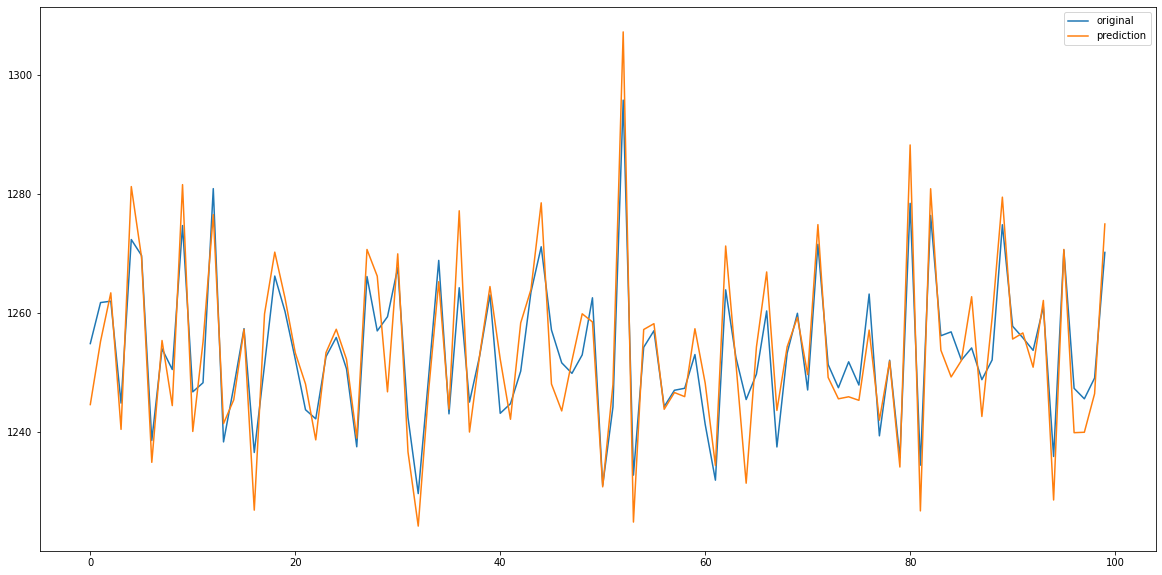

In [ ]:
# visualization-partial
prediction = predict(X_val, Θ, idx_best)

plt.figure(figsize=(20,10))
plt.plot(y_val[1900:])
plt.plot(prediction[1900:])
plt.legend(['original', 'prediction'])
plt.show()

# Conclusion

In this project, we applied gradient decent with adaptive momentum to train the model. And, random search was adopted to find the best hyperparameters. After several tests, we had the following hyperparameters with which the model had the minimum mean squared error.

**Hyperparameters:**
- batch size: 512
- learning rate (α): 0.01
- regularization parameter (λ): 0.1

With these hyperparameters, the minimum mean squared error we had on training set is about **8.764162**, about **28.719374** on validation set.